In [3]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [298]:
data = pd.read_csv('./var.csv')
data.head()

,simplified.significance,AA.wt,pos,AA.mut,year,foldx.ddg,covar.2d,Allele.Frequency,cb.nbr.cat,Allele.Count,genomic.locus,inheritance,disease.cat,protein,variant,AC.gnomAD
0,pathogenic,R,303,C,2018.0,1.156203,0.656840,0.000020,buried,1,22-40757536-C-T,AR,metabolic,ADSL,ADSL_R303C,5
1,pathogenic,R,426,H,2018.0,1.100152,0.840247,0.000199,buried,1,22-40760969-G-A,AR,metabolic,ADSL,ADSL_R426H,49
2,pathogenic,K,246,E,2017.0,8.890600,0.520974,0.000025,buried,1,22-40756440-A-G,AR,metabolic,ADSL,ADSL_K246E,7
3,benign,K,147,M,2019.0,-0.419810,0.287928,0.004325,buried,1,22-40750289-A-T,AR,metabolic,ADSL,ADSL_K147M,1199
4,pathogenic,A,2,V,2012.0,NaN,NaN,0.000115,NaN,1,22-40742567-C-T,AR,metabolic,ADSL,ADSL_A2V,29


In [5]:
data.tail()

,simplified.significance,AA.wt,pos,AA.mut,year,foldx.ddg,covar.2d,Allele.Frequency,cb.nbr.cat,Allele.Count,genomic.locus,inheritance,disease.cat,protein,variant,AC.gnomAD
8485,gnomAD,V,84,M,2017.0,1.928160,0.663212,0.000004,buried,1,3-10183781-G-A,AD,cancer,VHL,VHL_V84M,1
8486,1/10k,R,200,W,2017.0,-0.942926,0.960276,0.000209,exposed,58,3-10191605-C-T,AD,cancer,VHL,VHL_R200W,58
8487,1/10k,P,25,L,2017.0,NaN,0.040587,0.002996,NaN,507,3-10183605-C-T,AD,cancer,VHL,VHL_P25L,507
8488,1/10k,P,40,L,2017.0,NaN,0.260363,0.000248,NaN,45,3-10183650-C-T,AD,cancer,VHL,VHL_P40L,45
8489,1/10k,P,81,S,2017.0,1.846070,0.677461,0.000220,exposed,57,3-10183772-C-T,AD,cancer,VHL,VHL_P81S,57


### Creating Data Report

In [6]:
#profile = ProfileReport(data, \
#                        title="Data Profile")
#profile.to_file("./data_report.html")

### Finding and counting missing values

In [7]:
data.isna().sum()

simplified.significance       0
AA.wt                         0
pos                           0
AA.mut                        0
year                          4
foldx.ddg                  3402
covar.2d                   2346
Allele.Frequency              0
cb.nbr.cat                 3251
Allele.Count                  0
genomic.locus               920
inheritance                   0
disease.cat                   0
protein                       0
variant                       0
AC.gnomAD                     0
dtype: int64

### Plotting two important columns in data

/home/dispel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dispel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


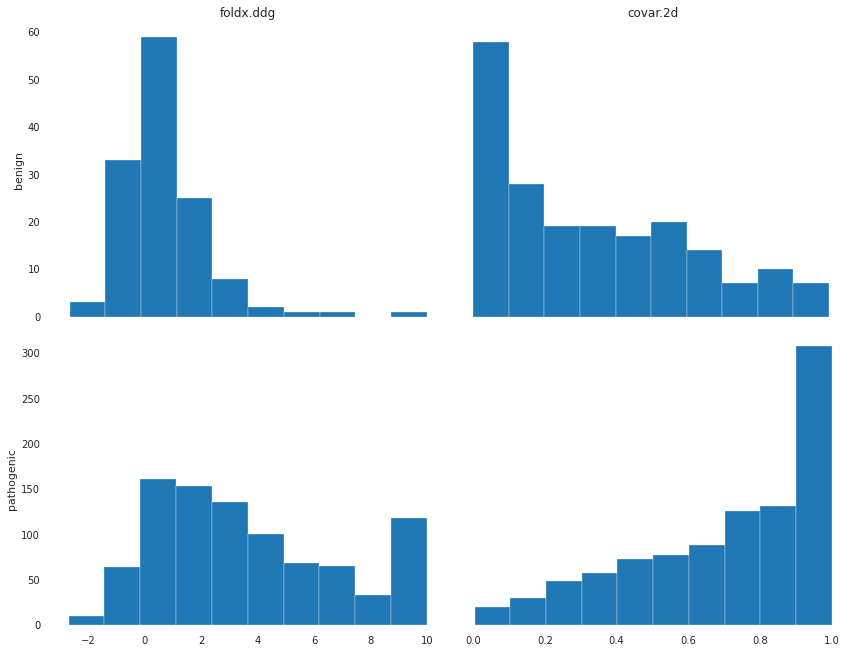

In [8]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,10))
#ax = ax.ravel() 
mask = data['simplified.significance'] == 'benign'
ax[0,0].hist(data[mask]['foldx.ddg'].values)
ax[0,0].set_ylabel('benign')
ax[0,0].set_title('foldx.ddg')
ax[0,1].hist(data[mask]['covar.2d'].values)
ax[0,1].set_title('covar.2d')
mask = data['simplified.significance'] == 'pathogenic'
ax[1,0].hist(data[mask]['foldx.ddg'].values)
#ax[1,0].set_title('Histogram: foldx.ddg (pathogenic)')
ax[1,0].set_ylabel('pathogenic')
ax[1,1].hist(data[mask]['covar.2d'].values)
ax[0,1].set_title('covar.2d')
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
#plt.tight_layout()
#plt.savefig('./histograms.png')

### Extracting features from amino acids using NLF Encode

In [9]:
nlf = pd.read_csv('https://raw.githubusercontent.com/dmnfarrell/epitopepredict/master/epitopepredict/mhcdata/NLF.csv',index_col=0)

def nlf_encode(seq):    
    '''
    '''
    
    x = pd.DataFrame([nlf[i] for i in seq]).reset_index(drop=True)  
    #show_matrix(x)
    e = x.values.flatten()
    return e

In [10]:
nlf_wt = []
for aa in data['AA.wt'].values:
    nlf_wt.append(nlf_encode(aa))
nlf_wt = np.array(nlf_wt)

In [11]:
nlf_mut = []
for aa in data['AA.mut'].values:
    nlf_mut.append(nlf_encode(aa))
nlf_mut = np.array(nlf_mut)

In [12]:
std = StandardScaler()
nlf_wt = std.fit_transform(nlf_wt)
nlf_mut = std.fit_transform(nlf_mut)

### One hot encoding and scaling foldx.ddg and covar.2d features

In [13]:
def to_hot(df, col):
    '''
    '''
    na_mask = df[col].notna()
    temp = np.zeros((len(df), 2))
    mu = df[col].mean()
    sd = df[col].std()
    df[col][na_mask] = (df[col][na_mask] - mu)/sd
    temp[np.where(na_mask == True),0] = 1
    temp[np.where(na_mask == True),1] = df[na_mask][col]
    
    return temp

In [14]:
onehot_foldx = to_hot(data, 'foldx.ddg')
onehot_covar = to_hot(data, 'covar.2d')

/home/dispel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Scaling Allele Frequency feature

In [15]:
data_allele = data['Allele.Frequency']
mu = data_allele.mean()
sd = data_allele.std()
data_allele = (data_allele - mu)/sd 

In [16]:
def to_onehot(data, col):
    '''
    '''
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import LabelEncoder
    
    ohe = OneHotEncoder()
    le = LabelEncoder()
    ohe_fit = ohe.fit_transform(data[col].values.reshape(-1,1)).toarray()
    
    return ohe_fit

In [17]:
out_inh = to_onehot(data, 'inheritance')
out_disease = to_onehot(data, 'disease.cat')
cus = np.hstack((out_inh, out_disease))

### Combining all features into a new matrix

In [200]:
features = np.c_[nlf_wt, nlf_mut, onehot_foldx, onehot_covar, cus, data_allele.values]

### Preparing data for machine learning

In [203]:
le = LabelEncoder()

mask1 = data['simplified.significance'] == 'pathogenic'
mask2 = data['simplified.significance'] == 'benign'
labels = data['simplified.significance'][(mask1 == True) | (mask2 == True)]

y_le = le.fit_transform(labels)

In [204]:
new_data = features[np.where((mask1 == True) | (mask2 == True))]

In [205]:
X_train, X_test, y_train, y_test = train_test_split(new_data, y_le, \
                                                   test_size=0.2, random_state=1)

### GP Optimization to find best parameters

In [208]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from sklearn.svm import SVC
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['poly', 'rbf', 'linear', 'sigmoid'], name="kernel")]
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['rbf', 'linear', 'sigmoid', 'poly'], name='kernel')]

clf = SVC()

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [209]:
res = gp_minimize(objective, space, n_calls=20, acq_func='EI',\
                  n_random_starts=2, random_state=1)

In [210]:
res.x

[637.6695888379611, 88.30977983023897, 'linear']

In [211]:
clf = SVC(C=res.x[0], gamma=res.x[1], kernel=res.x[2])
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9442446043165468, 0.920863309352518)

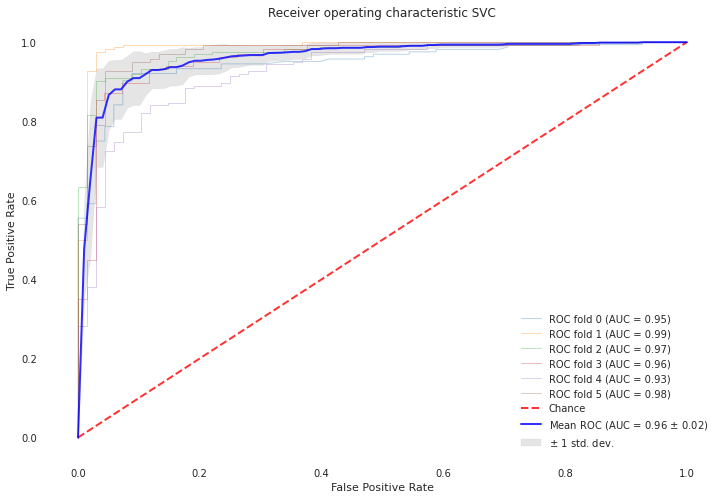

In [213]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

cv = StratifiedKFold(n_splits=6)
classifier = SVC(C=res.x[0], gamma=res.x[1], \
                     kernel=res.x[2],\
                 random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(new_data, y_le)):
    classifier.fit(new_data[train], y_le[train])
    viz = plot_roc_curve(classifier, new_data[test], y_le[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',\
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),\
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,\
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],\
       title="Receiver operating characteristic SVC")
ax.legend(loc="lower right")
plt.savefig('./roc_auc_svc.png')
plt.show()

In [24]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from sklearn.linear_model import LogisticRegression
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['poly', 'rbf', 'linear', 'sigmoid'], name="kernel")]
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Categorical(['l1', 'l2'], name='penalty'),\
         Categorical([ 'liblinear', 'saga'], name='solver')]

lr = LogisticRegression()

@use_named_args(space)
def objective(**params):
    lr.set_params(**params)

    return -np.mean(cross_val_score(lr, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [25]:
res_lr = gp_minimize(objective, space, n_calls=20, acq_func='EI',\
                  n_random_starts=2, random_state=1)

In [26]:
res_lr.x

[997.1848137540578, 'l2', 'liblinear']

In [27]:
lr = LogisticRegression(C=res_lr.x[0], penalty=res_lr.x[1],
                       solver=res_lr.x[2])
lr.fit(X_train, y_train)

LogisticRegression(C=997.1848137540578, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9424460431654677, 0.920863309352518)

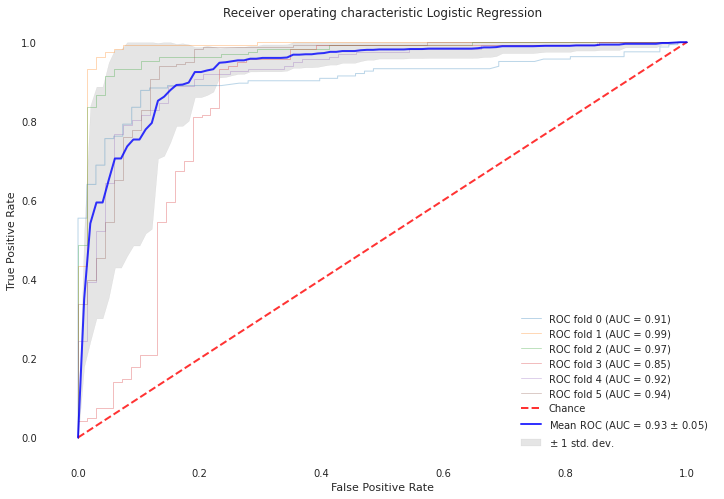

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression(C=res_lr.x[0], penalty=res_lr.x[1], \
                     solver=res_lr.x[2],\
                 random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(new_data, y_le)):
    classifier.fit(new_data[train], y_le[train])
    viz = plot_roc_curve(classifier, new_data[test], y_le[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',\
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),\
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,\
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],\
       title="Receiver operating characteristic Logistic Regression")
ax.legend(loc="lower right")
plt.savefig('./roc_auc_lr.png')
plt.show()

### Base

In [33]:
data.head()

,simplified.significance,AA.wt,pos,AA.mut,year,foldx.ddg,covar.2d,Allele.Frequency,cb.nbr.cat,Allele.Count,genomic.locus,inheritance,disease.cat,protein,variant,AC.gnomAD
0,pathogenic,R,303,C,2018.0,1.156203,0.656840,0.000020,buried,1,22-40757536-C-T,AR,metabolic,ADSL,ADSL_R303C,5
1,pathogenic,R,426,H,2018.0,1.100152,0.840247,0.000199,buried,1,22-40760969-G-A,AR,metabolic,ADSL,ADSL_R426H,49
2,pathogenic,K,246,E,2017.0,8.890600,0.520974,0.000025,buried,1,22-40756440-A-G,AR,metabolic,ADSL,ADSL_K246E,7
3,benign,K,147,M,2019.0,-0.419810,0.287928,0.004325,buried,1,22-40750289-A-T,AR,metabolic,ADSL,ADSL_K147M,1199
4,pathogenic,A,2,V,2012.0,NaN,NaN,0.000115,NaN,1,22-40742567-C-T,AR,metabolic,ADSL,ADSL_A2V,29


In [316]:
mask1 = data['foldx.ddg'].notna()
mask2 = data['covar.2d'].notna()
data = data[mask1 & mask2]
X = data[['foldx.ddg', 'covar.2d']].values
y = data['simplified.significance'].values

In [318]:
X = X[np.where((y == 'benign') | (y == 'pathogenic'))]
y = y[np.where((y == 'benign') | (y == 'pathogenic'))]

In [324]:
le = LabelEncoder()
y_le_base = le.fit_transform(y)

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y_le_base, test_size=0.2,\
                                                   random_state=1)

In [326]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8896882494004796, 0.861244019138756)

In [75]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from sklearn.linear_model import LogisticRegression
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['poly', 'rbf', 'linear', 'sigmoid'], name="kernel")]
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Categorical(['l1', 'l2'], name='penalty'),\
         Categorical([ 'liblinear', 'saga'], name='solver')]

lr = LogisticRegression()

@use_named_args(space)
def objective(**params):
    lr.set_params(**params)

    return -np.mean(cross_val_score(lr, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [76]:
res_lr_base = gp_minimize(objective, space, n_calls=20, acq_func='EI',\
                  n_random_starts=2, random_state=1)

In [77]:
res_lr_base.x

[0.5542007920459019, 'l2', 'saga']

In [78]:
lr = LogisticRegression(C=res_lr_base.x[0], penalty=res_lr_base.x[1],
                       solver=res_lr_base.x[2])
lr.fit(X_train, y_train)

LogisticRegression(C=0.5542007920459019, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.7735849056603774, 0.6666666666666666)

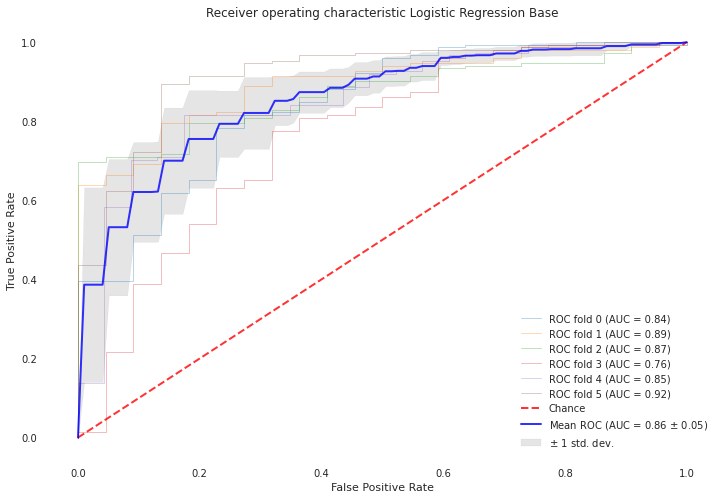

In [328]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression(random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(X, y_le_base)):
    classifier.fit(X[train], y_le_base[train])
    viz = plot_roc_curve(classifier, X[test], y_le_base[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',\
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),\
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,\
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],\
       title="Receiver operating characteristic Logistic Regression Base")
ax.legend(loc="lower right")
plt.savefig('./roc_auc_lr_base.png')
plt.show()

In [329]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_train, y_train), svc.score(X_test, y_test)

(0.8788968824940048, 0.84688995215311)

In [330]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from sklearn.svm import SVC
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['poly', 'rbf', 'linear', 'sigmoid'], name="kernel")]
'''
space  = [Real(10**-3, 10**3, "uniform", name='C'),\
          Real(10**-3, 10**3, "uniform", name='gamma'),\
          Categorical(['rbf', 'linear', 'sigmoid', 'poly'], name='kernel')]

clf = SVC()

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [331]:
res_svc_base = gp_minimize(objective, space, n_calls=20, acq_func='EI',\
                  n_random_starts=2, random_state=1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9683
Function value obtained: 0.1271
Current minimum: 0.1271
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 44.8015
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.5814
Function value obtained: 0.1786
Current minimum: 0.1211
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 47.8557
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 5 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 47.3533
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 6 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 46.1439
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 7 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 46.1237
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 8 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 46.0700
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 9 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 45.2736
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 10 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 45.0017
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 11 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 46.9338
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 12 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 46.2148
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 13 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 46.0511
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 14 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 45.3716
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 15 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 46.1178
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 16 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 45.5186
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 17 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 45.1139
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 18 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 46.1562
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 19 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 46.0910
Function value obtained: 0.1211
Current minimum: 0.1211
Iteration No: 20 started. Searching for the next optimal point.


/home/dispel/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 45.6486
Function value obtained: 0.1211
Current minimum: 0.1211


In [332]:
res_svc_base.x

[999.0405162836296, 236.08974086299918, 'linear']

In [333]:
clf = SVC(C=res_svc_base.x[0], gamma=res_svc_base.x[1], \
          kernel=res_svc_base.x[2])
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8788968824940048, 0.84688995215311)

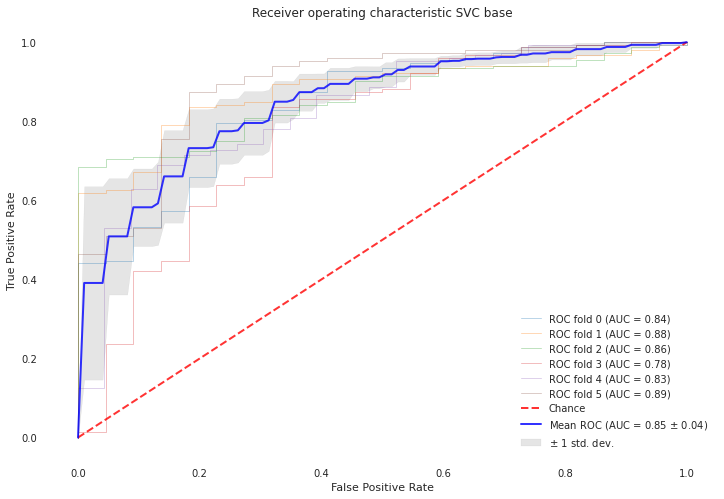

In [334]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

cv = StratifiedKFold(n_splits=6)
classifier = SVC(C=res_svc_base.x[0], gamma=res_svc_base.x[1], \
                     kernel=res_svc_base.x[2],\
                 random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12,8))
for i, (train, test) in enumerate(cv.split(X, y_le_base)):
    classifier.fit(X[train], y_le_base[train])
    viz = plot_roc_curve(classifier, X[test], y_le_base[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',\
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),\
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,\
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],\
       title="Receiver operating characteristic SVC base")
ax.legend(loc="lower right")
plt.savefig('./roc_auc_svc_base.png')
plt.show()

In [85]:
data = data.dropna()

In [218]:
AC = data[['covar.2d', 'Allele.Frequency']].values
patho = data['simplified.significance'].values

In [219]:
AC = AC[np.where((patho == 'pathogenic') | (patho == 'benign'))]
patho = patho[np.where((patho == 'pathogenic') | (patho == 'benign'))]

In [220]:
le = LabelEncoder()
patho_le = le.fit_transform(patho)

In [124]:
std = StandardScaler()
AC_std = std.fit_transform(AC)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(AC_std, patho_le, test_size=0.2,\
                                                   random_state=1)

In [126]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.7641509433962265, 0.7037037037037037)

In [127]:
clf = SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7037037037037037

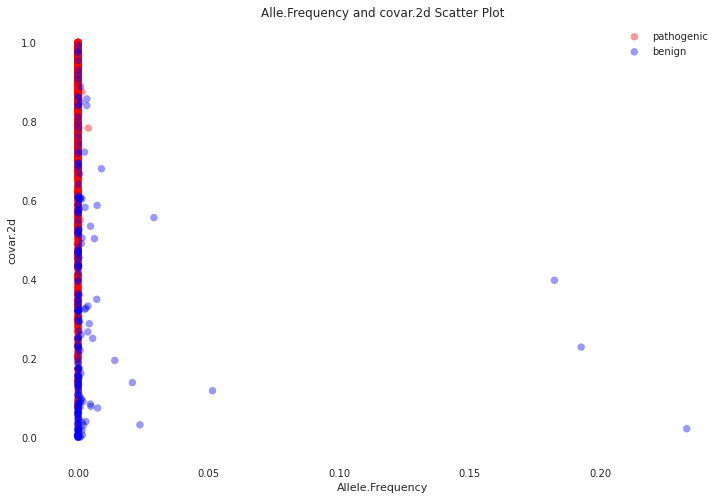

In [255]:
color = np.where(patho == 'pathogenic', 'red', 'blue')
plt.figure(figsize=(12,8))
plt.scatter(AC[:,1][patho == 'pathogenic'], AC[:,0][patho == 'pathogenic'], \
            c=color[patho == 'pathogenic'], alpha=0.4, label='pathogenic')
plt.scatter(AC[:,1][patho == 'benign'], AC[:,0][patho == 'benign'], \
            c=color[patho == 'benign'], alpha=0.4, label='benign')
plt.xlabel('Allele.Frequency')
plt.ylabel('covar.2d')
plt.title('Alle.Frequency and covar.2d Scatter Plot')
plt.legend()
plt.savefig('./scatterplot.png')

In [132]:
import statsmodels.api as sm

In [141]:
data = sm.datasets.scotland.load(as_pandas=False)

In [336]:
X_train = sm.add_constant(X_train)

In [337]:
mod = sm.GLM(y_train, X_train, \
             family=sm.families.Binomial(link=sm.genmod.families.links.logit))

/home/dispel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


In [338]:
mod_results = mod.fit()

In [339]:
print(mod_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  834
Model:                            GLM   Df Residuals:                      831
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -224.36
Date:                Sun, 26 Apr 2020   Deviance:                       448.72
Time:                        01:21:07   Pearson chi2:                     780.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4834      0.222     -2.174      0.0

In [340]:
X_test = sm.add_constant(X_test)
preds = (mod.predict(mod_results.params, X_test) > 0.5) * 1

In [341]:
from sklearn.metrics import accuracy_score

In [342]:
accuracy_score(y_test, preds)

0.8803827751196173

In [343]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.861244019138756